In [1]:
# Importing Modules
import pandas as pd
import numpy as np
import gensim, re, os 
import string, glob
import subprocess
import multiprocessing
import pickle as pk
import time, sys, datetime
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import CountVectorizer
from rake_nltk import Rake
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from sklearn.decomposition import FactorAnalysis, PCA, FastICA, DictionaryLearning, NMF, TruncatedSVD, LatentDirichletAllocation

from gensim import corpora
from gensim.models import TfidfModel, LdaSeqModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.test.utils import common_corpus

import scienceplots
# Set up matplotlib
plt.style.use(['science','notebook'])

## Data Loading & EDA

In [2]:
# Importing Data
df = pd.read_csv("../data/tweets_PDChina_All.csv", low_memory=False).dropna()
# Take a look at the first few rows
df.head()

,Unnamed: 0,likes,url,timestamp,Date,replies,html,retweets,text,fullname,id,user
0,0.0,0.0,/PDChina/status/168013610180812801,2012-02-10T16:49:00,2012-02-10,0.0,"<p class=""TweetTextSize js-tweet-text tweet-te...",0.0,Mainland China UnionPay expands to online stor...,"People's Daily,China",1.680140e+17,PDChina
1,1.0,0.0,/PDChina/status/168013283855568897,2012-02-10T16:47:43,2012-02-10,0.0,"<p class=""TweetTextSize js-tweet-text tweet-te...",0.0,26 countries jointly boycott EU 'carbon tax' ....,"People's Daily,China",1.680130e+17,PDChina
2,2.0,0.0,/PDChina/status/168012807550414849,2012-02-10T16:45:49,2012-02-10,0.0,"<p class=""TweetTextSize js-tweet-text tweet-te...",0.0,Safeguarding Chinese employees abroad. 从利比亚到埃及...,"People's Daily,China",1.680130e+17,PDChina
3,3.0,0.0,/PDChina/status/168012080895635459,2012-02-10T16:42:56,2012-02-10,0.0,"<p class=""TweetTextSize js-tweet-text tweet-te...",0.0,Most provinces raise minimum wage in China in ...,"People's Daily,China",1.680120e+17,PDChina
4,4.0,0.0,/PDChina/status/168011642662174720,2012-02-10T16:41:11,2012-02-10,0.0,"<p class=""TweetTextSize js-tweet-text tweet-te...",0.0,UN: Young people suffer from highest unemploym...,"People's Daily,China",1.680120e+17,PDChina


In [3]:
def get_year(string_date):
    # Convert string to datetime object
    date = datetime.datetime.strptime(string_date, "%Y-%m-%d")
    return date.year

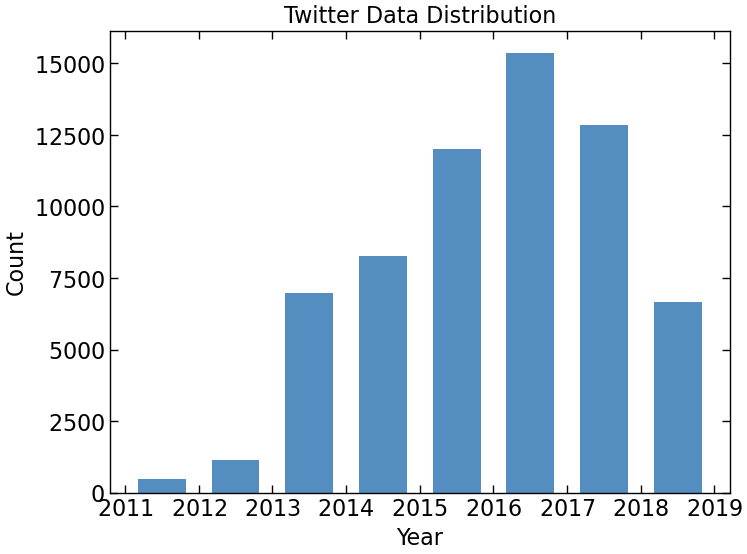

In [4]:
# Plot the distribution of the data
# We first convert the date column to a list of years
# Then we plot the histogram
date_lst = [get_year(_) for _ in df['Date'].tolist()]
ax = plt.hist(date_lst, bins=sorted(list(set(date_lst))) + [2019], alpha=0.7, rwidth=0.65)
plt.title("Twitter Data Distribution")
plt.xlabel("Year")
plt.ylabel("Count")
plt.locator_params(axis='y', nbins=8)
plt.locator_params(axis='x', nbins=10)
plt.tick_params(which='minor', bottom=False, top=False, left=False, right=False)

We can observe that the tweet frequency is much higher in the period of 2015-2018.

## Data Cleaning

In [5]:
# In this section, we will perform some data cleaning
# We will first remove all the punctuations and digits
# Then we will remove all the stopwords
# Finally, we will lemmatize the words

np.random.seed(42)

lemma = WordNetLemmatizer()

exclude = set(string.punctuation)
exclude.update(set(string.digits))
include = set(string.printable)

stop = set(stopwords.words('english'))
self_defined = ['are', 'more', 'this', 'its', 'has', 'have', 'or', 'was', 'which', 'their', 'about', 'one', 'not', 'who', 'other', 'they', 'all', 'he', 'were', 'will', 'up', 'been', 'than', 'when', 'some', 'also',
 'said', 'there', 'two', 'his', 'out', 'had', 'no', 'into', 'would', 'we', 'if', 'most', 'people', 'over', 'so', 'only', 'them', 'first', 'after', 'what', 'can', 'i', 'now', 'last', 'many', 'you', 'like',
 'us', 'because', 'even', 'could', 'where', 'just', 'such', 'do', 'made', 'may', 'she', 'here', 'her', 'through', 'then', 'these', 'any', 'three', 'well', 'says', 'before', 'much', 'our', 'those',
 'still', 'my', 'him', 'very', 'between', 'dr', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday',
'january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december', 
               'mr', 'mrs' 'you', 'it', 'per', 'china', 'chinese', 'dont', 'report', 'show', 'article', 'news', 'photo',
               'dr', 'miss', 'mr', 'st', 'ave', 'street', 'pm', 'time', 'today', 'year', 'though', 'didnt', 'get',
               'make', 'way', 'big', 'going', 'another', 'including', 'already', 'think', 'take', 'Might', 'around', 'without', 'thing', 'day',  'might', 'need', 'see', 'thats', 'there', 'around', 'never',  'put', 'need', 'want', 'rd', 'w', 'e','sat',
               'east', 'noon', 'night', 'according', 'part', 'le', 'another' , 'going', 'tell', 'later', 'day', 'minute', 'give',
               'another', 'problem', 'recent', 'among', 'might', 'go', 'ago',  'think', 'b', 'want', 'come' , 'several', 'called', 'whether', 'thcentury', 'c', 'yearold']

stop.update(self_defined)
THRESHOLD = 8

origin = ['hong kong', 'north korea', 'new york', 'south korea', 'united state', 'united kingdom', ' corp ',
          ' cant ', 'white house', 'united nation']
joined = ['hong-kong', 'north-korea', 'new-york', 'south-korea', 'united-state', 'united-kingdom', ' corporation ',
          ' cannot ', 'white-house', 'united-nation']

origin_local = []
joined_local = []

In [6]:
## Key Phrase Extraction & Merge with RAKE
def rake_extract(doc, topk = 100):
    r = Rake(min_length=2, max_length=2)
    r.extract_keywords_from_text(" ".join(doc).lower())
    phrases = r.get_ranked_phrases_with_scores()
    global origin_local, joined_local
    for i, _ in enumerate(phrases):
        if i >= topk:
            break
        origin_local.append(_[1])
        joined_local.append(_[1].replace(' ', '-'))

In [7]:
## Data clearning
def clean(doc):
    doc = doc.lower()
    doc = re.sub(r'\s+', ' ', doc)
    punc_free = ''.join(ch for ch in doc if ch in include)
    punc_free = ''.join(ch for ch in punc_free if ch not in exclude)
    global origin_local, joined_local
    for o, j in zip(origin_local, joined_local):
        punc_free = punc_free.replace(o, j)
    stop_free = ' '.join([i for i in punc_free.split() if i not in stop])
    normalized = ' '.join(lemma.lemmatize(word) for word in stop_free.split())
    stop_free = ' '.join([i for i in normalized.split() if i not in stop])
    return stop_free.split()

In [8]:
text_lst = df['text'].tolist()
## HTML Link Removal
nolink_text_lst = [re.sub(r'http\S+', '', _) for _ in  text_lst] 
nolink_text_lst = [re.sub(r'pic\.twitter\.com/\S+', '', _) for _ in  nolink_text_lst] 

## Remove non-English Characters
eng_text_lst = [_.encode("ascii", errors="ignore").decode() for _ in nolink_text_lst]

rake_extract(eng_text_lst, 100)
print("RAKE Finished:", datetime.datetime.now())

with multiprocessing.Pool(4) as pool:
    cleaned_text_lst = pool.map(clean, eng_text_lst)
print("CLean Finished:", datetime.datetime.now())

RAKE Finished: 2023-11-08 05:43:08.811446
CLean Finished: 2023-11-08 05:43:11.077856


In [9]:
# We will show how the data cleaning works
# We will first show the original text
print("Original Text:", text_lst[0])
# Then we will show the text after removing the links
print("Link removed Text:", nolink_text_lst[0])
# Then we will show the text after removing the non-English characters
print("English-only Text:", eng_text_lst[0])
# Finally, we will show the text after cleaning, lemmatising, and removing stopwords
print("Final Clean Text:", cleaned_text_lst[0])

Original Text: Mainland China UnionPay expands to online store in Taiwan. 银联卡在台湾刷卡交易服务范围正式从实体商店扩大到网络商店。http://english.people.com.cn/90778/7725836.html …
Link removed Text: Mainland China UnionPay expands to online store in Taiwan. 银联卡在台湾刷卡交易服务范围正式从实体商店扩大到网络商店。 …
English-only Text: Mainland China UnionPay expands to online store in Taiwan. 
Final Clean Text: ['mainland', 'unionpay', 'expands', 'online', 'store', 'taiwan']


In [10]:
from gensim import corpora
from gensim.models import LdaSeqModel

dictionary = corpora.Dictionary(cleaned_text_lst)
doc_term_matrix = [dictionary.doc2bow(x) for x in cleaned_text_lst]

for key in dictionary.token2id.keys():
    dictionary.id2token[dictionary.token2id[key]] = key

We train the topic model in the following line. Where we set the number of topic to be 6, and feed in the number of articles of each time slice (year). Here we specifically set the chain_variance to a higher value (0.5) to highlight the model's capacity in modelling the varying semantics over the time slices.

In [11]:
ldaseq = LdaSeqModel(corpus=doc_term_matrix, id2word=dictionary.id2token, 
                     time_slice=list(ax[0]), num_topics=6, chain_variance=0.5, random_state=42, passes=100,  chunksize=1000)

In [12]:
ldaseq.save('./ldaseq_topic6_hv.tpc')

Here we save the model's topic assignment to a csv table for future use.  

In [13]:
topic_assignment_lst = []
for doc_number in range(len(doc_term_matrix)):
    topic_assignment = ldaseq.doc_topics(doc_number)
    topic_assignment_lst.append(topic_assignment.argmax(-1))

df['topic'] = topic_assignment_lst
#df.to_csv("../data/tweets_PDChina_All_with_topic.csv", sep=',', index=False, encoding='utf-8')

We now have a trained topic model. We can probe what topics the model has learned. In this example, we exam the topics of year 2016-2017.

In [14]:
for topic_num in range(6):
    topic = ldaseq.print_topic(topic=topic_num, time=5, top_terms=30)
    print("This is topic {}, the topic is consisted of the following words:".format(topic_num+1))
    print([_[0] for _ in topic])
    print("---------------------------------------")

This is topic 1, the topic is consisted of the following words:
['woman', 'man', 'online', 'world', 'team', 'new', 'robot', 'life', 'human', 'sign', 'girl', 'hospital', 'beijing', 'help', 'child', 'port', 'art', 'road', 'taking', 'win', 'family', 'german', 'court', 'stunning', 'couple', 'young', 'yi', 'gold', 'role', 'better']
---------------------------------------
This is topic 2, the topic is consisted of the following words:
['police', 'military', 'near', 'dead', 'force', 'missile', 'student', 'death', 'air', 'drill', 'southchinasea', 'aircraft', 'attack', 'sea', 'school', 'pla', 'training', 'ship', 'island', 'least', 'navy', 'medium', 'flight', 'plane', 'south', 'toll', 'dog', 'taiwan', 'jet', 'water']
---------------------------------------
This is topic 3, the topic is consisted of the following words:
['world', 'new', 'million', 'country', 'pic', 'market', 'largest', 'company', 'billion', 'trade', 'build', 'project', 'yuan', 'power', 'beijing', 'bank', 'top', 'shanghai', 'inves

After a comprehensive analysis, we can distill distinct meanings from each topic, thereby sharpening our interpretive acumen. Let's delve into the specifics:

Topic 1: **Daily Human Interactions** - This topic is woven into the fabric of everyday life, as suggested by key terms like 'woman', 'man', 'online', 'life', 'robot', and 'world'. These words sketch a vivid tableau of our routine existence and interactions in the digital era.

Topic 2: **Conflict and Warfare** - Marked by a lexicon of tension and strife—'police', 'military', 'near', 'dead', 'missile', 'death', 'student', 'force', 'aircraft'—this topic underscores the grim realities of global unrest and the machinery of war.

Topic 3: **Global Economics and Commerce** - This topic is clearly entrenched in the world of finance and trade, with 'world', 'new', 'country', 'million', 'pic', 'market', 'largest', 'company', 'build', 'billion', and 'trade' signaling a discourse dominated by market dynamics and corporate strategies.

Topic 4: **Domestic Governance** - The mention of former Chinese Prime Minister Keqiang Li, along with terms tied to economic expansion, positions this topic squarely in the realm of national policy and administrative maneuvers.

Topic 5: **Urgent Developments** - Words like 'killed', 'injured', 'train', 'hit', 'beijing', 'tourist', 'earthquake' point to the unpredictable and often tragic nature of breaking news, capturing moments of crisis that demand immediate public attention.

Topic 6: **International Diplomacy** - The inclusion of 'xijinping', 'dprk', 'visit', 'cooperation', 'beijing', 'realdonaldtrump', and 'russian' reflects the intricate dance of global politics, hinting at narratives of power, alliance, and international relations.

However, certain terms, such as "sw," "nw," and "th," elude clear categorization, likely serving as noise rather than signal. To refine our model, a supplementary phase of data cleansing is advisable to prune these outliers.

Additionally, monitoring the evolution of a topic can yield insights into changing discourses over time. By tracking the word composition of Topic 6 from 2011 to 2019, for instance, we can chart the transformation in diplomatic engagements and geopolitical rhetoric, thus gaining a longitudinal perspective on shifts in international politics.

In [15]:
for time_marker in range(8):
    topic = ldaseq.print_topic(topic=5, time=time_marker, top_terms=100)
    print("This is year {}-{}, the topic is consisted of the following words:".format(time_marker+2011, time_marker+2012))
    print([_[0] for _ in topic])
    print("---------------------------------------")

This is year 2011-2012, the topic is consisted of the following words:
['president', 'th', 'visit', 'xi', 'minister', 'hong', 'state', 'jinping', 'south', 'foreign', 'held', 'beijing', 'korea', 'kong', 'ceremony', 'leader', 'cooperation', 'national', 'new', 'session', 'prime', 'un', 'dprk', 'japan', 'russian', 'issue', 'tie', 'army', 'attend', 'meeting', 'met', 'talk', 'country', 'hold', 'ministry', 'top', 'taiwan', 'relation', 'pakistan', 'united', 'political', 'meet', 'urged', 'member', 'african', 'obama', 'russia', 'visiting', 'secretary', 'anniversary', 'peace', 'arrested', 'military', 'wang', 'dance', 'defense', 'korean', 'parade', 'mark', 'security', 'international', 'moon', 'border', 'posted', 'counterpart', 'special', 'arrived', 'fm', 'interest', 'japanese', 'syria', 'bilateral', 'facebook', 'conference', 'suspect', 'government', 'victim', 'hope', 'wed', 'republic', 'agreed', 'tue', 'summit', 'nanjing', 'trade', 'spokesman', 'sco', 'strategic', 'egypt', 'forum', 'kim', 'zhang',

Year after year, the focal points within our topic landscape have shifted, mirroring the ebb and flow of global events. For instance, "DPRK" ascended to a position of prominence between 2015 and 2018. This trend is reflective of North Korea's escalated military endeavors during Kim Jong-un's tenure, capturing the world's attention.

Concurrently, "Hong Kong" became increasingly salient from 2011 through 2014. This period saw growing strains between the Chinese central government and the Hong Kong Special Administrative Region, culminating in the Umbrella Movement of 2014. The surge in mentions of "Hong Kong" encapsulates the build-up to these pivotal pro-democracy protests, signifying a period marked by calls for greater autonomy and political reform.